## Imports

In [1]:
import sys, os
sys.path.append("/workspace") 
sys.path.append("/workspace/helpers_root") 
sys.path.append("/workspace/msml610/tutorials") 
os.environ["CSFY_GIT_ROOT_PATH"] = "/workspace/msml610"

### Install packages

In [2]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet jupyterlab-vim)"
!jupyter labextension enable

In [3]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet graphviz)"

In [4]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet dataframe_image)"

In [5]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet jupyterlab-hide-code)"

In [6]:
!pip install arviz
!pip install pymc
!pip install preliz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.2/529.2 kB 4.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.0/149.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 15.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.2 MB/s eta 0:00:0000:0100:01


### Import modules

In [7]:
%load_ext autoreload
%autoreload 2
import logging

import arviz as az
import pandas as pd
import xarray as xr
import pymc as pm
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import preliz as pz

import ipywidgets as widgets
from IPython.display import display

In [8]:
import msml610_utils as ut

ut.config_notebook()

# Setting notebook style
# Notebook signature
Python 3.12.3
Linux 24effd99422c 5.15.167.4-microsoft-standard-WSL2 #1 SMP Tue Nov 5 00:21:55 UTC 2024 x86_64 x86_64 x86_64 GNU/Linux
numpy version=2.3.5
pymc version=5.26.1
matplotlib version=3.10.7
arviz version=0.22.0
preliz version=0.23.0


# Probability distributions

## Bernoulli

- A **Bernoulli variable** is a random variable that takes only two possible values.
  - Typically, these values are $1$ (success) and $0$ (failure).

- **Definition:**
  - $X \sim \text{Bernoulli}(p)$ means $P(X = 1) = p$ and $P(X = 0) = 1 - p$
  - The parameter $p$ represents the probability of success, where $0 \leq p \leq 1$.

- **Intuition:**
  - Represents a single trial of an experiment that can result in one of two outcomes.
  - Examples:
    - Coin flip: $X = 1$ if heads, $X = 0$ if tails.
    - Answer correctness: $X = 1$ if correct, $X = 0$ if incorrect.

In [9]:
# Set random seed for reproducibility.
np.random.seed(42)

# Define an interactive function.
def sample_bernoulli(n: int =4, p: float=0.35) -> None:
    data = stats.bernoulli.rvs(p=p, size=n)
    print(f"Bernoulli(p={p}) - {n} realizations:")
    print(data)

# Create interactive sliders.
widgets.interact(
    sample_bernoulli,
    n=widgets.IntSlider(value=4, min=1, max=50, step=1, description='n (samples)'),
    p=widgets.FloatSlider(value=0.35, min=0.0, max=1.0, step=0.01, description='p (success prob)')
);

interactive(children=(IntSlider(value=4, description='n (samples)', max=50, min=1), FloatSlider(value=0.35, de…

## Binomial

A **binomial random variable** represents the number of successes in a fixed number of independent trials, where each trial has two possible outcomes: success or failure.

- **Parameters:**
  - $n$: number of trials  
  - $p$: probability of success in each trial

- **Probability formula:**
  $$
  P(X = k) = \binom{n}{k} p^k (1 - p)^{n - k}
  $$
  where $k = 0, 1, 2, \dots, n$

- **Example:**
  - If you flip a fair coin 10 times, the number of heads follows a `Binomial(10, 0.5)` distribution

In [10]:
# Set random seed for reproducibility
np.random.seed(42)

# Define interactive function with type hints
def sample_binomial(n: int = 4, p: float = 0.35, trials: int = 10) -> None:
    """
    Sample n values from a Binomial(trials, p) distribution and print them.
    """
    data: np.ndarray = stats.binom.rvs(n=trials, p=p, size=n)
    print(f"Binomial(n={trials}, p={p}) - {n} realizations:")
    print(data)

# Create interactive sliders
widgets.interact(
    sample_binomial,
    n=widgets.IntSlider(value=4, min=1, max=50, step=1, description='n (samples)'),
    trials=widgets.IntSlider(value=10, min=1, max=100, step=1, description='trials per sample'),
    p=widgets.FloatSlider(value=0.35, min=0.0, max=1.0, step=0.01, description='p (success prob)')
);

interactive(children=(IntSlider(value=4, description='n (samples)', max=50, min=1), FloatSlider(value=0.35, de…

In [11]:
params = {
    #"kind": "cdf",
    "kind": "pdf",
    "pointinterval": False,
    "interval": "hdi",   # Highest density interval.
    #"interval": "eti",  # Equally tailed interval.
    "xy_lim": "auto"
}

#help(pz.Binomial.plot_interactive)

# Probability of k successes on N trials flipping a coin with p success
pz.Binomial(p=0.5, n=5).plot_interactive(**params)

interactive(children=(IntSlider(value=5, description='n (0, inf)', max=15, style=SliderStyle(description_width…

In [12]:
ut.plot_binomial()

(3, 5)


<Figure size 800x300 with 0 Axes>

## Beta

- Continuous prob distribution defined in [0, 1]
- It is useful to model probability or proportion
    - E.g., the probability of success in a Bernoulli trial

- alpha represents "success" parameter
- beta represents "failure" parameter
    - When alpha is larger than beta the distribution skews toward 1, indicating a higher probability of success
    - When alpha = beta the distribution is symmetric and centered around 0.5

In [13]:
# Set random seed for reproducibility.
np.random.seed(42)

# Define an interactive function.
def sample_beta(n: int, a: float, b: float) -> None:
    """
    Sample n values from a Beta(a, b) distribution and print them.
    """
    data: np.ndarray = stats.beta.rvs(a=a, b=b, size=n)
    print(f"Beta(a={a}, b={b}) - {n} realizations:")
    print(data)

# Create interactive sliders.
widgets.interact(
    sample_beta,
    n=widgets.IntSlider(value=4, min=1, max=50, step=1, description='n (samples)'),
    a=widgets.FloatSlider(value=2.0, min=0.1, max=10.0, step=0.1, description='α (shape1)'),
    b=widgets.FloatSlider(value=5.0, min=0.1, max=10.0, step=0.1, description='β (shape2)')
);

interactive(children=(IntSlider(value=4, description='n (samples)', max=50, min=1), FloatSlider(value=2.0, des…

In [14]:
params = {
    #"kind": "cdf",
    "kind": "pdf",
    "pointinterval": False,
    "interval": "hdi",   # Highest density interval.
    #"interval": "eti",  # Equal tailed interval.
    "xy_lim": "auto"
}

alpha = 3.0
beta = 1.0

pz.Beta(alpha=alpha, beta=beta).plot_interactive(**params)

interactive(children=(FloatSlider(value=3.0, description='alpha (0, inf)', max=13.0, min=2.220446049250313e-16…

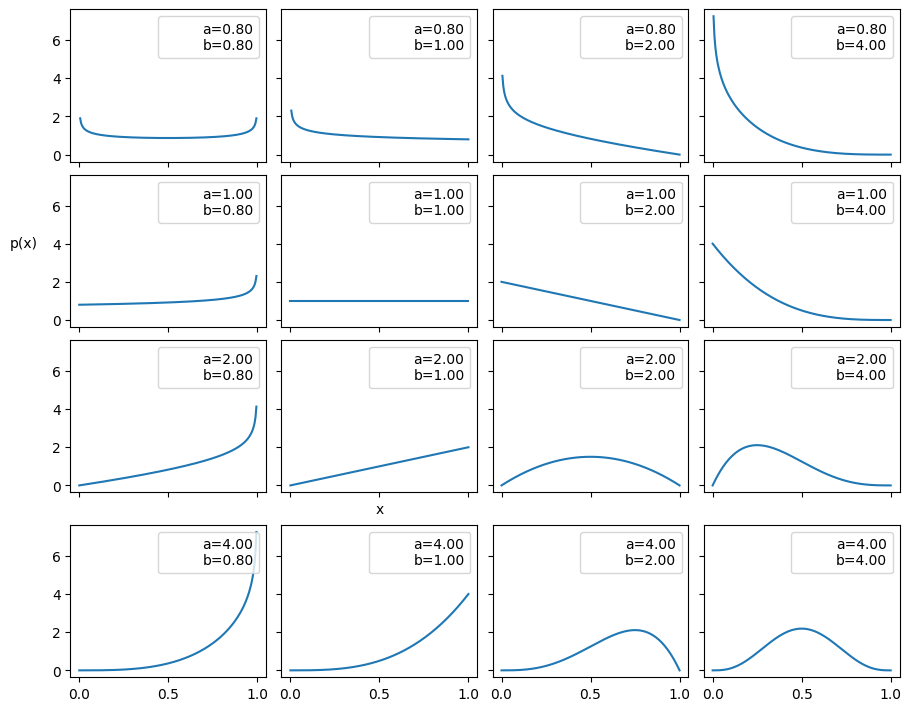

In [15]:
ut.plot_beta()

# Coin Example: Analytical Solution

In [16]:
# prior=(1, 1) -> uniform
# (20, 20) -> "Gaussian" centered around 0.5
# (1, 4) -> "Exponential" centered around 0

# theta = 0.35, 1.00

In [17]:
ut.beta_prior_interactive()

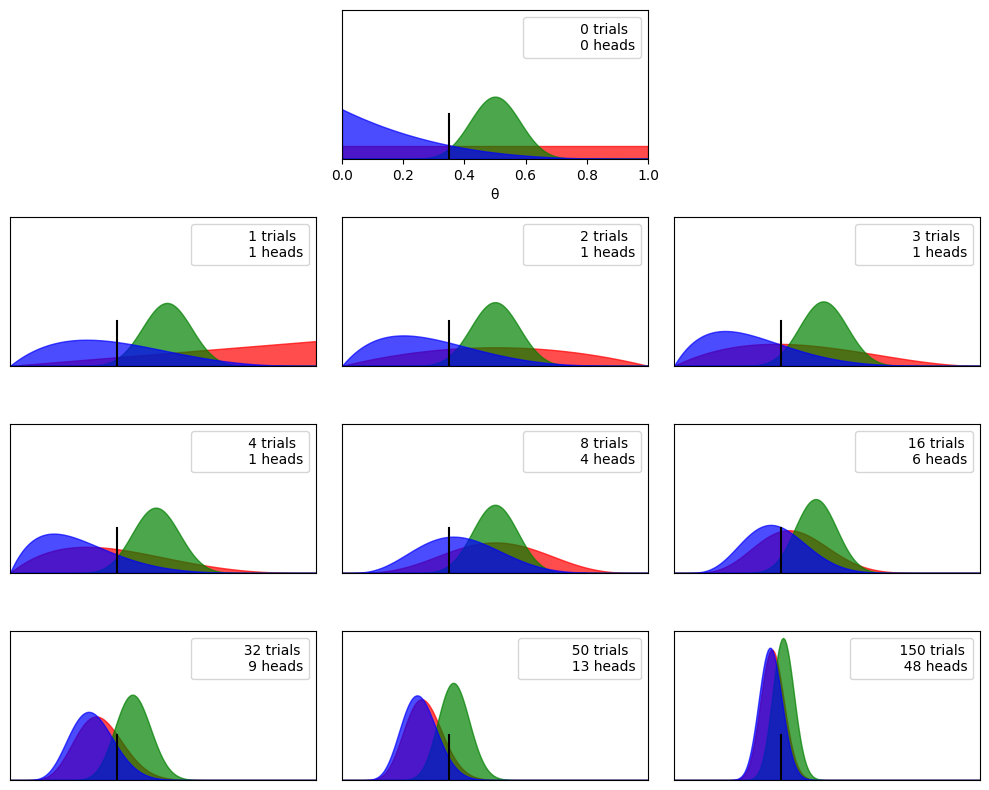

In [18]:
ut.update_prior()

# Coin Example: Numerical Solution

- It's a synthetic example!
  - Assume you know the true value of $\theta$ (not true in general)

- **Workflow**
  - Model the prior $\theta$ and the likelihood $Y | \theta$
    \begin{equation*}
      \begin{cases}
      \theta \sim \text{Beta}(\alpha = 1, \beta = 1) \\
      Y \sim \text{Binomial}(n = 1, p = \theta) \\
      \end{cases}
    \end{equation*}
  - Observe samples of the variable $Y$
  - Run inference
  - Generate samples of the posterior
  - Summarize posterior
     - E.g., Highest-Posterior Density (HPD)
  - ...

In [19]:
# Generate data from ground truth model.

np.random.seed(123)
n = 4
# Unknown value.
theta_real = 0.35

# Generate some observational data.
data1 = stats.bernoulli.rvs(p=theta_real, size=n)
data1

array([1, 0, 0, 0])

In [20]:
# Build PyMC model matching mathematical model.

with pm.Model() as model1:
    # Prior.
    theta = pm.Beta('theta', alpha=1., beta=1.)
    # Likelihood.
    y = pm.Bernoulli('y', p=theta, observed=data1)
    # (Numerical) Inference to estimate the posterior distribution through samples.
    idata1 = pm.sample(1000, random_seed=123)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


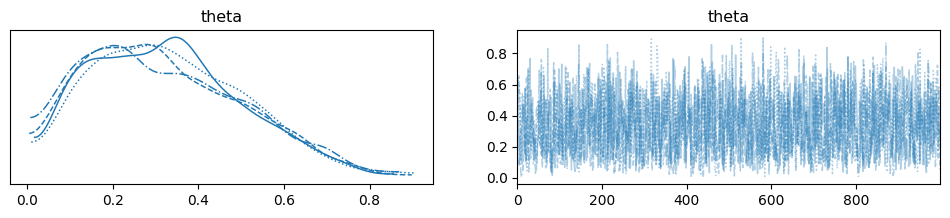

In [21]:
az.plot_trace(idata1);

- PyMC uses NUTS sampler, computes 4 chains
- No trace diverges
- Kernel density estimation (KDE) for posterior (should be Beta)


In [22]:
#?az.summary

In [23]:
az.summary(idata1, kind="stats")

,mean,sd,hdi_3%,hdi_97%
theta,0.326,0.178,0.04,0.654


- Traces appear "noisy" and non-diverging (good)
- Numerical summary of posterior: mean, std dev, HDI
- $E[\hat{\theta}] \approx 0.324$
- $\Pr(\hat{\theta} \in [0.031, 0.653]) = 0.94$

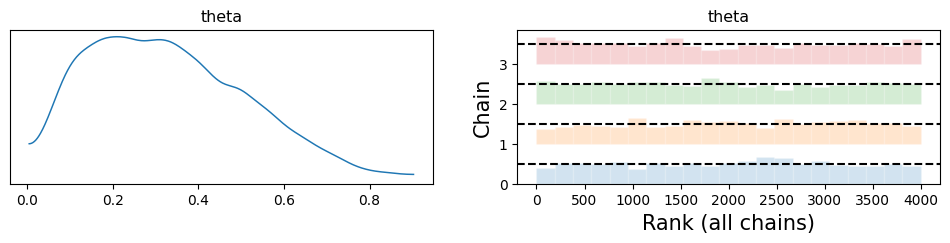

In [24]:
az.plot_trace(idata1, kind="rank_bars", combined=True);

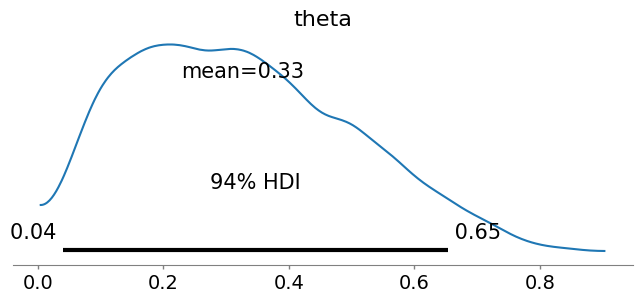

In [25]:
az.plot_posterior(idata1);

## More data

In [26]:
np.random.seed(123)
n = 20

# Unknown value.
theta_real = 0.35

# Generate some observational data.
data2 = stats.bernoulli.rvs(p=theta_real, size=n)
data2

array([1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0])

In [27]:
with pm.Model() as model2:
    # Prior.
    theta = pm.Beta('theta', alpha=1., beta=1.)
    # Likelihood.
    y = pm.Bernoulli('y', p=theta, observed=data2)
    # (Numerical) Inference to estimate the posterior distribution through samples.
    idata2 = pm.sample(1000, random_seed=123)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [28]:
az.summary(idata2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
theta,0.318,0.098,0.142,0.498


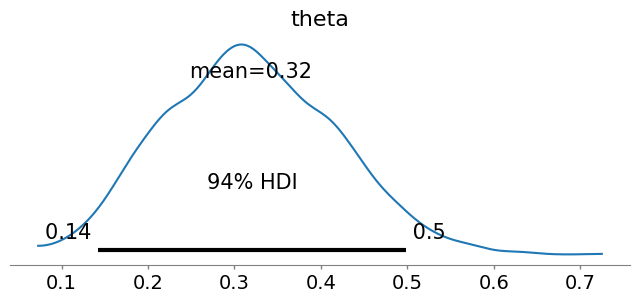

In [29]:
az.plot_posterior(idata2);

## Even more data

In [30]:
np.random.seed(123)
n = 100
# Unknown value.
theta_real = 0.35

# Generate some observational data.
data3 = stats.bernoulli.rvs(p=theta_real, size=n)
data3

array([1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0])

In [31]:
with pm.Model() as model3:
    # Prior.
    theta = pm.Beta('theta', alpha=1., beta=1.)
    # Likelihood.
    y = pm.Bernoulli('y', p=theta, observed=data3)
    # (Numerical) Inference to estimate the posterior distribution through samples.
    idata3 = pm.sample(1000, random_seed=123)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [32]:
az.summary(idata3, kind="stats")

,mean,sd,hdi_3%,hdi_97%
theta,0.304,0.046,0.216,0.388


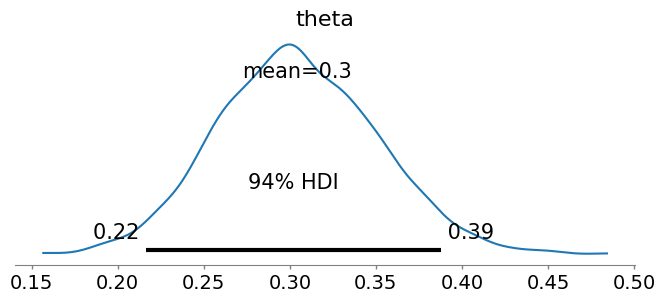

In [33]:
az.plot_posterior(idata3);

## Savage-Dickey ratio

arviz - WARNING - The reference value is outside of the posterior. This translate into infinite support for H1, which is most likely an overstatement.


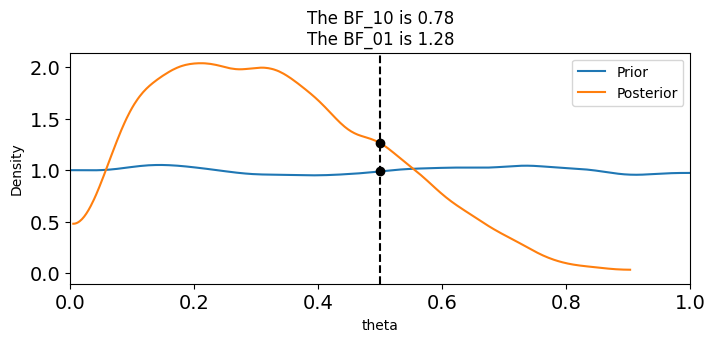

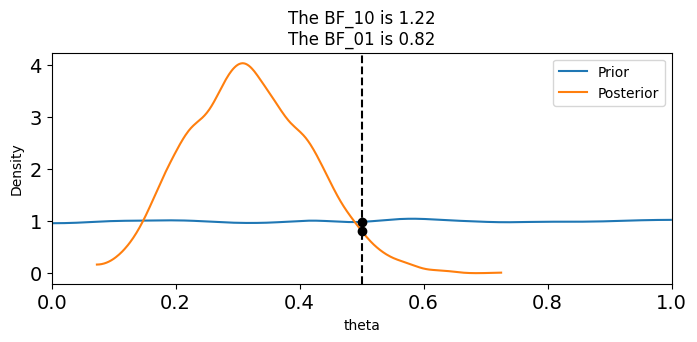

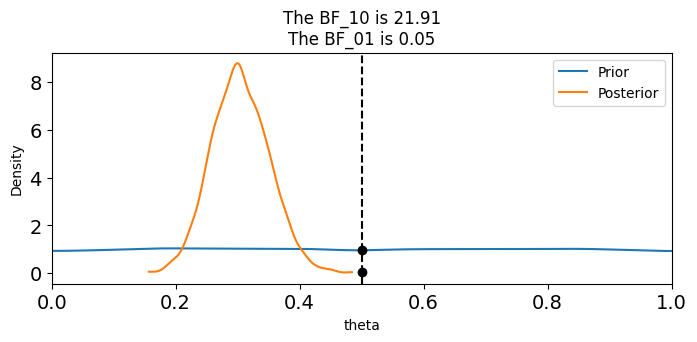

In [34]:
for idata in [idata1, idata2, idata3]:
    az.plot_bf(idata, var_name="theta", prior=np.random.uniform(0, 1, 10000), ref_val=0.5);
    plt.xlim(0, 1);

## ROPE

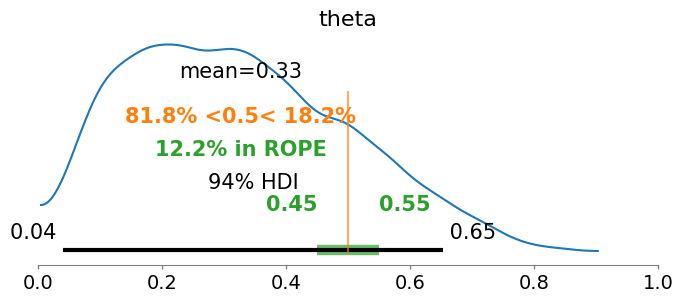

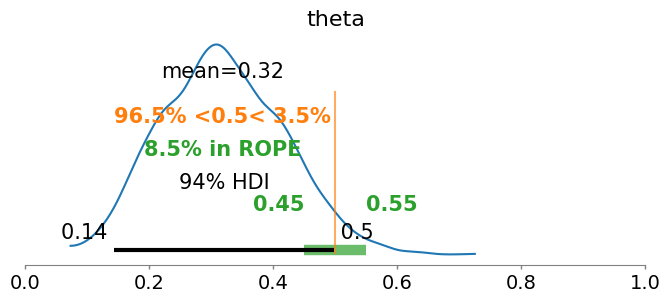

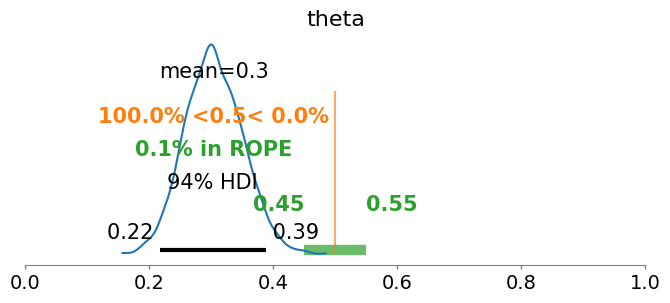

In [35]:
for idata in [idata1, idata2, idata3]:
    az.plot_posterior(idata, rope=[0.45, .55], ref_val=0.5)
    plt.xlim(0, 1);

# Decision with loss function

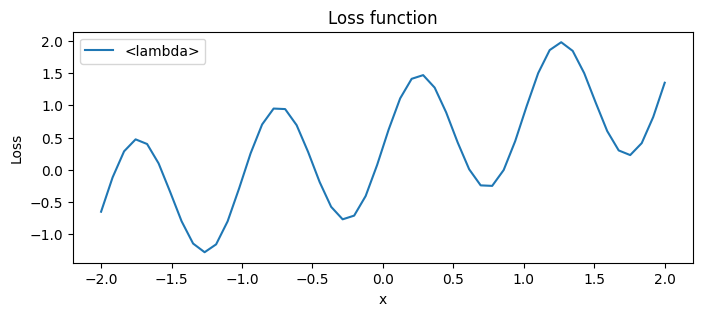

In [36]:
#loss_func = lambda x: ut.squared_loss(x, theta_real)
#loss_func = lambda x: ut.abs_loss(x, theta_real)
#loss_func = lambda x: ut.asymmetric_loss(x, theta_real)
loss_func = lambda x: ut.sin_loss(x, theta_real)

grid = np.linspace(-2.0, 2.0, 50)
ut.plot_loss(grid, loss_func)

In [37]:
idata1.to_dataframe()[("posterior", "theta")]

0       0.118336
1       0.313811
2       0.379870
3       0.349804
4       0.349804
          ...   
3995    0.143560
3996    0.301813
3997    0.582238
3998    0.517732
3999    0.403143
Name: (posterior, theta), Length: 4000, dtype: float64

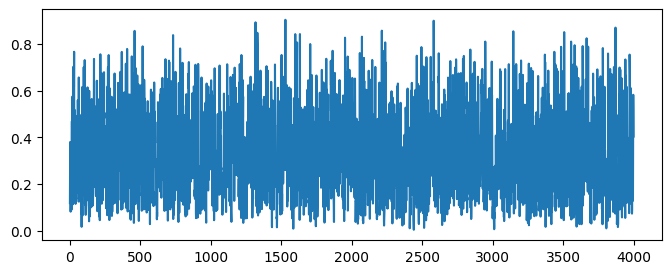

In [38]:
plt.plot(idata1.to_dataframe()[("posterior", "theta")]);

<Axes: ylabel='Density'>

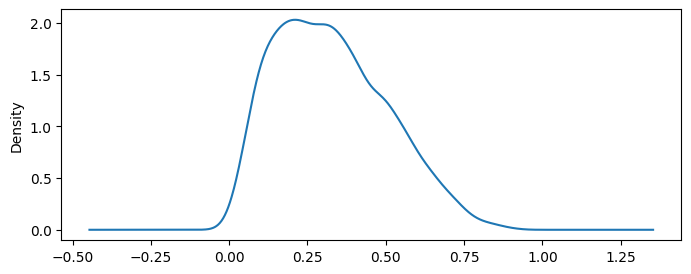

In [39]:
df = idata1.to_dataframe()[("posterior", "theta")]
df.plot(kind="kde")

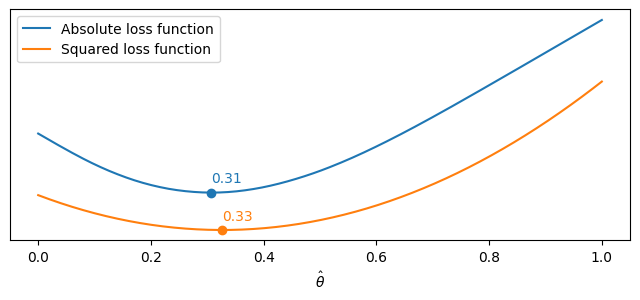

In [40]:
ut.pick_best_theta(idata1)

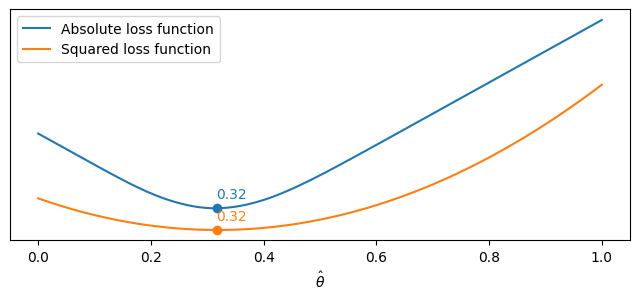

In [41]:
ut.pick_best_theta(idata2)